In [1]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


/tmp/ipykernel_57691/3514129619.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import requests

In [3]:
# import urllib3

In [4]:
# http = urllib3.PoolManager()

# Functions

In [5]:
ws_hostname = "127.0.1.1"
ws_hostname = "172.27.0.64"


street_field  = "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "postName"
country_field =  "countryName"
addr_key_field = "referenceKey"

# ws_hostname = "192.168.1.3"

In [6]:

sample_size = None# 1000
def get_addresses(addresses_filename):
    addresses = pd.read_csv(addresses_filename,  
                            usecols = lambda x: x in [addr_key_field, "addr_key",
                                       country_field, 
                                       postcode_field, 
                                       city_field, 
                                       street_field, 
                                       housenbr_field,
                                       country_field], 
                           dtype={postcode_field: str, housenbr_field: str, country_field: str})
    
    
    addresses = addresses.rename(columns={"addr_key": addr_key_field})
    if country_field in addresses: 
        addresses[country_field] =addresses[country_field].fillna("Belgique")
    else: 
        addresses[country_field] = "Belgique"
    #addresses = addresses.rename(columns={"index":addr_key_field})
    
    addresses = addresses[addresses[street_field].notnull() & addresses[city_field].notnull()] # & addresses[country_field].isnull() ]
    
    addresses[postcode_field] = addresses[postcode_field].astype(str)
    
    if sample_size: 
        addresses = addresses.sample(sample_size, random_state=0)
    
    return addresses#.drop(country_field, axis=1)

In [7]:
def call_ws(addr_data, check_result=True, structured_osm=False, with_rejected=False, mode="long", extra_house_number=True): #lg = "en,fr,nl"
    t = datetime.now()
    
    fields = { 
            "checkResult" : check_result,
            "structuredOsm" : structured_osm,
            "withRejected": with_rejected,
            "extraHouseNumber": extra_house_number,
            "mode": mode
        }

    if isinstance(addr_data, pd.Series):
        addr_data = addr_data.to_dict()
        
    data = {"address": addr_data    }

        
    try: 
        r = requests.post(
        f'http://{ws_hostname}:5000//REST/nominatimWrapper/v1/geocode',
            params=fields,
            json=data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
#     print(r)
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
#            res = r.text
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [8]:
def split_columns(addresses_batch):
    output = pd.DataFrame(index=addresses_batch.index, dtype=str)

    for f in addresses_batch:
#        print(f)
        grp= addresses_batch[f].apply(lambda r : pd.Series(r, dtype=str) if pd.notnull(r) else pd.Series(dtype=str)) 
        grp = pd.concat({f: grp}, names=['L0', 'L1'], axis=1)
        
        output = pd.concat([output, grp], axis=1)
    # display(output)
    output.columns = pd.MultiIndex.from_tuples(output.columns)
    return output  

In [9]:
def format_ws_res(addresses):
    # assert addresses.json.apply(lambda js: "match" in js).all()
    assert addresses.json.apply(lambda js: len(js["match"])==1 if js is not None and "match" in js else True).all()
    addresses_out = addresses.json.apply(lambda js: pd.Series(js["match"][0]) if js is not None and "match" in js else pd.Series(dtype=object))
    #reject_out = addresses.json.apply(lambda js: pd.Series(js["rejected"][0]) if js is not None and "rejected" in js else pd.Series(dtype=object))
    
    addresses_out =  split_columns(addresses_out)
    return addresses_out

In [10]:
def call_ws_batch(addr_data, mode="coordinates", with_rejected=False, check_result=True, structured_osm=False, extra_house_number=True): #lg = "en,fr,nl"
    #file_data = addr_data.to_csv(index=False)
    
    r = requests.post(
    f'http://{ws_hostname}:5000/REST/nominatimWrapper/v1/batchGeocode',
    params= { 
        'mode': mode,
        "withRejected": with_rejected,
        "checkResult" : check_result,
        "structuredOsm"   : structured_osm,
        "extraHouseNumber": extra_house_number
    },
    json={"addresses": addr_data.fillna('').to_dict(orient="records")}
    )
    
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return None, None
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
        return None, None
    elif r.status_code == 200:
        
        try:

            res_json = json.loads(r.text)
            if "match" in res_json:
                match =  split_columns(pd.DataFrame(res_json["match"]))
                rejected= split_columns(pd.DataFrame(res_json["rejected"])) if "rejected" in res_json and len(res_json["rejected"])>0 else pd.DataFrame()

            else :
                match =  split_columns(pd.DataFrame(res_json))
                rejected=None
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)

            return r.text, None
    
    return match, rejected 
    


# Calls

## Single address calls

In [11]:
res=call_ws({
#         addr_key_field: 5,
        street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=True, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'fast',
    'referenceKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.032053}

In [12]:
res=call_ws({
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
         street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"
}, check_result=True, structured_osm=False, with_rejected=False, mode="long")
res

Argument error
{"message": "Field 'fullAddress' cannot be used together with fields postName;streetName;postCode;countryName;houseNumber"}



In [13]:
res=call_ws({
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
}, check_result=False, structured_osm=False, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'libpostal+regex[lpost]+photon',
    'referenceKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny - Fonsnylaan, 20, 1060 Saint-Gilles - Sint-Gillis, België / Belgique / Belgien',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.392867}

In [14]:
res=call_ws({

    addr_key_field: 5,
    street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=True, structured_osm=True, with_rejected=True, extra_house_number=True)
res

{'match': [{'metadata': {'method': 'orig',
    'referenceKey': '5',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'libpostalHouseNumber': ['20', ''],
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {'simStreetWhich': 'street_name',
    'simStreet': 1.0,
    'simCity': 0.46153846153846156,
    'simPostCode': 1.0,
    'simHouseNumber': 1.0}}],
 'rejected': [{'metadata': {'method': 'orig',
    'referenceKey': '

## Batch calls (row by row)

In [15]:
addresses = pd.concat([
   get_addresses("data/address_restobe.csv.gz").assign(dataset="resto"),
   get_addresses("data/address_best.csv.gz").assign(dataset="best"),
   get_addresses("data/address_cbe.csv.gz").assign(dataset="cbe")
])
addresses = addresses.reset_index(drop=True)
addresses[addr_key_field] = addresses.index.astype(str)
addresses

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,0
1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,1
2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,2
3,rue du Centre,200,WAIMES,4950,Belgique,resto,3
4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,4
...,...,...,...,...,...,...,...
2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,2995
2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,2996
2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,2997
2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,2998


In [16]:
addresses = addresses.sample(100)

In [17]:
# addresses = pd.read_csv("data/address_bad.csv")
# addresses
iter_per_sec_stats={}


### Simple way

In [18]:
# addresses = addresses[addresses.streetName.str.lower().str.contains("steenweg op antwerpen")]

# # addresses = addresses.loc[[100,112,118,142,155,179,198]]
# # addresses = addresses.loc[[ 94,  100,  198, ]]
# addresses = addresses.loc[0:100]
# addresses

In [19]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq.fillna("").progress_apply(call_ws, check_result=False, 
                                                                structured_osm=False, 
                                                                with_rejected=True, 
                                                                mode="short",axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_seq.shape[0]/tot_time
iter_per_sec_stats["sequential"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset:
# Normal mode: 128.78 seconds, 7.77 it/s
# Fastmode:     68.80 seconds, 14.54 it/s

#Resto dataset: 
# Normal mode: 145.73 seconds, 6.86 it/s
# Fast mode:    82.99 seconds, 12.05 it/s

# Best dataset:
# Normal mode: 108.53 seconds, 9.21 it/s
# Fast mode: 37.44 seconds, 26.71 it/s

addresses_seq

  0%|          | 0/100 [00:00<?, ?it/s]

No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}

7.20 seconds, 13.90 it/s


,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey,json
478,Chaussée de Louvain,922,EVERE,1140,Belgique,resto,478,"{'match': [{'metadata': {'method': 'fast', 're..."
958,Vrijheid,136,HOOGSTRATEN,2320,Belgique,resto,958,"{'match': [{'metadata': {'method': 'fast', 're..."
1432,Boulevard Belgica,3,Molenbeek-Saint-Jean,1080,Belgique,best,1432,"{'match': [{'metadata': {'method': 'fast', 're..."
1683,Ieperstraat,22A,Nieuport,8620,Belgique,best,1683,"{'match': [{'metadata': {'method': 'fast', 're..."
1394,Venusstraat,8,Willebroek,2830,Belgique,best,1394,"{'match': [{'metadata': {'method': 'fast', 're..."
...,...,...,...,...,...,...,...,...
2987,"Marloie, Rue des Prés",9,Marche-en-Famenne,6900,Belgique,cbe,2987,{'match': [{'metadata': {'method': 'libpostal+...
1942,Rue de Humain,47,Rochefort,5580,Belgique,best,1942,"{'match': [{'metadata': {'method': 'fast', 're..."
154,Leopold de Waelplaats,1,ANVERS-CENTRE,2000,Belgique,resto,154,"{'match': [{'metadata': {'method': 'fast', 're..."
1596,Léon Schreursvest,35,Louvain,3001,Belgique,best,1596,"{'match': [{'metadata': {'method': 'fast', 're..."


In [20]:
timing = addresses_seq[["dataset"]].copy()
timing["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
timing["method"] =addresses_seq.json.apply(lambda j: j["match"][0]["metadata"]["method"] if j else None) 

timing

,dataset,time,method
478,resto,0.047798,fast
958,resto,0.027520,fast
1432,best,0.030702,fast
1683,best,0.029478,fast
1394,best,0.028766,fast
...,...,...,...
2987,cbe,0.218776,libpostal+regex[lpost]
1942,best,0.018439,fast
154,resto,0.025597,fast
1596,best,0.017400,fast


<AxesSubplot:title={'center':'Avg call duration'}, xlabel='dataset'>

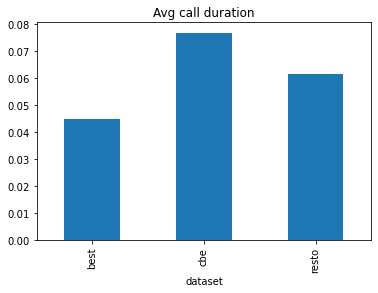

In [21]:
(timing.groupby("dataset").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:title={'center':'Avg call duration'}, xlabel='method'>

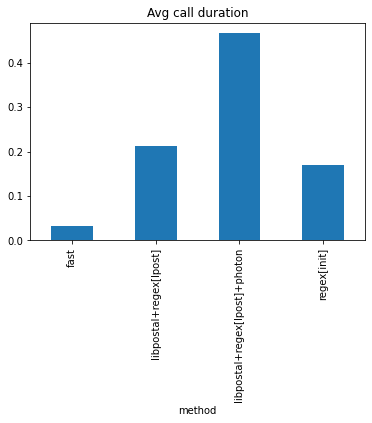

In [22]:
(timing.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:xlabel='dataset'>

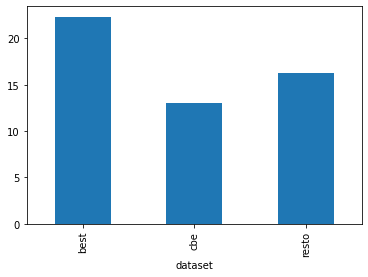

In [23]:
(1/timing.groupby("dataset").time.mean()).plot.bar("Iterations per seconds")

dataset
best     AxesSubplot(0.125,0.125;0.775x0.755)
cbe      AxesSubplot(0.125,0.125;0.775x0.755)
resto    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

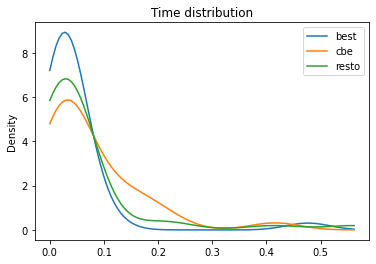

In [24]:
timing.groupby("dataset").time.plot.kde(legend=True, ind=np.linspace(0,timing.time.max(), 100 ), title="Time distribution" )

method
fast                             AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]           AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+photon    AxesSubplot(0.125,0.125;0.775x0.755)
regex[init]                      AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

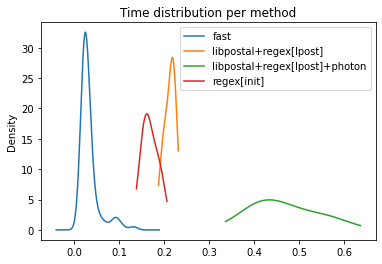

In [25]:
mthd_vc= timing.method.value_counts()
mthd_vc[mthd_vc==1]
timing[~timing.method.isin(mthd_vc[mthd_vc==1].index)][["method", "time"]].groupby("method").time.plot.kde(legend=True, title="Time distribution per method" )

<AxesSubplot:title={'center':'time'}, xlabel='[dataset]'>

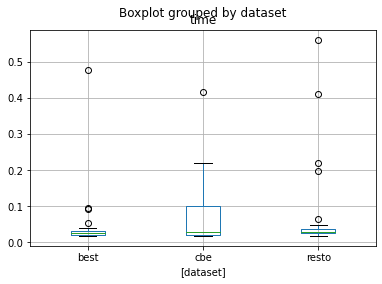

In [26]:
timing[["time", "dataset"]].boxplot(by="dataset")#.boxplot()

<AxesSubplot:title={'center':'Iterations per second'}>

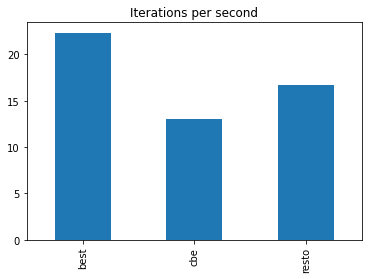

In [27]:
(timing.dataset.value_counts()/timing.groupby("dataset").time.sum()).plot.bar(title="Iterations per second")

In [28]:
addresses_seq_out = format_ws_res(addresses_seq)
addresses_seq_out

metadata                         \
                      method referenceKey placeRank   
478                     fast          478        30   
958                     fast          958        30   
1432                    fast         1432        30   
1683                    fast         1683        30   
1394                    fast         1394        30   
...                      ...          ...       ...   
2987  libpostal+regex[lpost]         2987        30   
1942                    fast         1942        30   
154                     fast          154        30   
1596                    fast         1596        30   
533                     fast          533        30   

                                      output                       \
                                  streetName houseNumber postCode   
478   Chaussée de Louvain - Leuvensesteenweg         922     1140   
958                                 Vrijheid         136     2320   
1432         Boulevard Belgica - Belgicalaan           3     1080   
1683                             Ieperstraat         22A     8620   
1394                             Venusstraat           8     2830   
...                                      ...         ...      ...   
2987                            Rue des Prés           9     6900   
1942                           Rue de Humain          47     5580   
154                    Leopold de Waelplaats           1     2000   
1596                       Léon Schreursvest          35     3001   
533       Avenue de Tervueren - Tervurenlaan           5     1040   

                                                                               \
                                        postName                  countryName   
478                                        Evere  België / Belgique / Belgien   
958                                  Hoogstraten  België / Belgique / Belgien   
1432  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
1683                                  Nieuwpoort  België / Belgique / Belgien   
1394                                  Willebroek  België / Belgique / Belgien   
...                                          ...                          ...   
2987                           Marche-en-Famenne  België / Belgique / Belgien   
1942                                    Havrenne  België / Belgique / Belgien   
154                                    Antwerpen  België / Belgique / Belgien   
1596                                    Heverlee  België / Belgique / Belgien   
533                                    Etterbeek  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
478   Chez Anesti, 922, Chaussée de Louvain - Leuven...          ['922', '']   
958   Restaurant-Hotel Lewis, 136, Vrijheid, Hoogstr...          ['136', '']   
1432  3, Boulevard Belgica - Belgicalaan, Molenbeek-...            ['3', '']   
1683  22A, Ieperstraat, Nieuwpoort, Veurne, West-Vla...          ['22a', '']   
1394  8, Venusstraat, Blaasveld, Willebroek, Mechele...            ['8', '']   
...                                                 ...                  ...   
2987  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...            ['9', '']   
1942  47, Rue de Humain, Havrenne, Buissonville, Roc...           ['47', '']   
154   Koninklijk Museum voor Schone Kunsten, 1, Leop...            ['1', '']   
1596  35, Léon Schreursvest, Matadi, Heverlee, Leuve...           ['35', '']   
533   NONA, 5, Avenue de Tervueren - Tervurenlaan, E...            ['5', '']   

                                                                 
                     lat                 lon              other  
478   50.858731399999996   4.413909061740533                NaN  
958          51.40261375   4.761471806978374                NaN  
1432          50.8661393           4.3389532   

In [29]:
# addresses_seq_out[addresses_seq_out[("output", "lat")].isnull()]

In [30]:
# rejected_seq_out = format_ws_res(rejected)
# rejected_seq_out

rejected = addresses_seq.json.apply(lambda js: pd.Series(js["rejected"]) if js is not None and "rejected" in js and len(js["rejected"])>0 else pd.Series(dtype=object))
rejected = rejected.unstack().dropna()
rejected = split_columns(rejected.apply(pd.Series))
rejected

metadata                                      \
                               method referenceKey placeRank rejectReason   
0 1394                           fast         1394        30         tail   
  2822                           fast         2822        26         tail   
  1693                           fast         1693        26         tail   
  1851                           fast         1851        26         tail   
  1920                           fast         1920        30         tail   
  589                            fast          589        30         tail   
  2618                           fast         2618        26         tail   
  2006                           fast         2006        26         tail   
  1601                           fast         1601        26         tail   
  82                             fast           82        30         tail   
  2069                           fast         2069        26         tail   
  431   libpostal+regex[lpost]+photon          431      26.0         tail   
  926          libpostal+regex[lpost]          926      30.0         tail   
  722                            fast          722        26         tail   
  92                             fast           92        26         tail   
  1799                           fast         1799        26         tail   
  2545                    regex[init]         2545        26         tail   
  617                            fast          617        30         tail   
  2320                           fast         2320        26         tail   
1 1394                           fast         1394        30         tail   
  2822                           fast         2822        26         tail   
  1851                           fast         1851        26         tail   
  2618                           fast         2618        26         tail   
  2069                           fast         2069        26         tail   
  431   libpostal+regex[lpost]+photon          431      26.0         tail   
  722                            fast          722        30         tail   
  92                             fast           92        27         tail   
  1799                           fast         1799        26         tail   
  2320                           fast         2320        26         tail   
2 1394                           fast         1394        30         tail   
  2822                           fast         2822        26         tail   
  1851                           fast         1851        26         tail   
  2618                           fast         2618        26         tail   
  431   libpostal+regex[lpost]+photon          431      27.0         tail   
  722                            fast          722        30         tail   
  1799                           fast         1799        26         tail   
  2320                           fast         2320        26         tail   
3 1394                           fast         1394        30         tail   
  2822                           fast         2822        26         tail   
  2618                           fast         2618        26         tail   
  722                            fast          722        30         tail   
  1799                           fast         1799        26         tail   
  2320                           fast         2320        27         tail   
4 2822                           fast         2822        26         tail   
  2618                           fast         2618        26         tail   
  722                            fast          722        30         tail   
  2320                           fast         2320        27         tail   
5 2822                           fast         2822        26         tail   
  2618                           fast         2618        26         tail   
  722                            fast          722        30         tail   
  2320                   

In [31]:
addresses_seq_out[addresses_seq_out[("metadata", "referenceKey")] == "443"]

Empty DataFrame
Columns: [(metadata, method), (metadata, referenceKey), (metadata, placeRank), (output, streetName), (output, houseNumber), (output, postCode), (output, postName), (output, countryName), (output, displayName), (output, libpostalHouseNumber), (output, lat), (output, lon), (output, other)]
Index: []

In [32]:
# addresses_seq_out[addresses_seq_out[("metadata", "retryOn26")] =="True"]

In [33]:
addresses_seq_out[("metadata", "method")].value_counts(dropna=False)

fast                             89
libpostal+regex[lpost]+photon     4
libpostal+regex[lpost]            3
regex[init]                       3
NaN                               1
Name: (metadata, method), dtype: int64

In [34]:
# addresses_seq_out[addresses_seq_out[("work", 0)].isnull()]
addresses_seq_out[addresses_seq_out[("metadata", "method")] != "fast"]

metadata                         \
                             method referenceKey placeRank   
2112  libpostal+regex[lpost]+photon         2112        26   
88           libpostal+regex[lpost]           88        30   
784                             NaN          NaN       NaN   
390   libpostal+regex[lpost]+photon          390        30   
1838  libpostal+regex[lpost]+photon         1838        26   
431   libpostal+regex[lpost]+photon          431        26   
926          libpostal+regex[lpost]          926        30   
2495                    regex[init]         2495        26   
2961                    regex[init]         2961        30   
2545                    regex[init]         2545        26   
2987         libpostal+regex[lpost]         2987        30   

                                        output                       \
                                    streetName houseNumber postCode   
2112                               Wochterberg         NaN     2200   
88    Rue Saint-Lambert - Sint-Lambertusstraat         202     1200   
784                                        NaN         NaN      NaN   
390                            Oude Koornmarkt           5     2000   
1838                    Place de la 7e Brigade         NaN     6900   
431                             Turnhoutsebaan         NaN     2970   
926           Rue des Tongres - Tongerenstraat          71     1040   
2495                         Rue de la Luzerne         NaN     5100   
2961                               Rue de Dave           5     5100   
2545                                 Grand'Rue         NaN     5651   
2987                              Rue des Prés           9     6900   

                                                     \
                                           postName   
2112                                      Herentals   
88    Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe   
784                                             NaN   
390                                       Antwerpen   
1838                              Marche-en-Famenne   
431                                         Schilde   
926                                       Etterbeek   
2495                                         Jambes   
2961                                         Jambes   
2545                                         Somzée   
2987                              Marche-en-Famenne   

                                   \
                      countryName   
2112  België / Belgique / Belgien   
88    België / Belgique / Belgien   
784                           NaN   
390   België / Belgique / Belgien   
1838  België / Belgique / Belgien   
431   België / Belgique / Belgien   
926   België / Belgique / Belgien   
2495  België / Belgique / Belgien   
2961  België / Belgique / Belgien   
2545  België / Belgique / Belgien   
2987  België / Belgique / Belgien   

                                                                              \
                                            displayName libpostalHouseNumber   
2112  Wochterberg, Herentals, Turnhout, Antwerpen, V...             ['', '']   
88    202, Rue Saint-Lambert - Sint-Lambertusstraat,...          ['202', '']   
784                                                 NaN                  NaN   
390   5, Oude Koornmarkt, Sint-Andries, Antwerpen, V...            ['5', '']   
1838  Place de la 7e Brigade, Marche-en-Famenne, Lux...            ['6', '']   
431   Turnhoutsebaan, Schilde, Antwerpen, Vlaanderen...      ['439-445', '']   
926   71, Rue des Tongres - Tongerenstraat, Etterbee...        ['71-76', '']   
2495  Rue de la Luzerne, Froidebise, Jambes, Namur, ...            ['3', '']   
2961  5, Rue de Dave, Jambes, Namur, Wallonie, 5100,...            ['5', '']   
2545  Grand'Rue, Ahérée, Somzée, Walcourt, Philippev...           ['62', '']   
2987  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...            ['9', '']   

                                             \
          

In [35]:
# call_ws(addresses_seq.loc[700], check_result=False, with_rejected=False)

In [36]:
# call_ws(addresses_seq.loc[4], check_result=False, with_rejected=True)

In [37]:
# addresses_seq_out[addresses_seq.json.apply(lambda js: "osmOrder" in js["match"][0]['work'] if js else None).fillna(False)]

In [38]:
addresses_seq

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey,json
478,Chaussée de Louvain,922,EVERE,1140,Belgique,resto,478,"{'match': [{'metadata': {'method': 'fast', 're..."
958,Vrijheid,136,HOOGSTRATEN,2320,Belgique,resto,958,"{'match': [{'metadata': {'method': 'fast', 're..."
1432,Boulevard Belgica,3,Molenbeek-Saint-Jean,1080,Belgique,best,1432,"{'match': [{'metadata': {'method': 'fast', 're..."
1683,Ieperstraat,22A,Nieuport,8620,Belgique,best,1683,"{'match': [{'metadata': {'method': 'fast', 're..."
1394,Venusstraat,8,Willebroek,2830,Belgique,best,1394,"{'match': [{'metadata': {'method': 'fast', 're..."
...,...,...,...,...,...,...,...,...
2987,"Marloie, Rue des Prés",9,Marche-en-Famenne,6900,Belgique,cbe,2987,{'match': [{'metadata': {'method': 'libpostal+...
1942,Rue de Humain,47,Rochefort,5580,Belgique,best,1942,"{'match': [{'metadata': {'method': 'fast', 're..."
154,Leopold de Waelplaats,1,ANVERS-CENTRE,2000,Belgique,resto,154,"{'match': [{'metadata': {'method': 'fast', 're..."
1596,Léon Schreursvest,35,Louvain,3001,Belgique,best,1596,"{'match': [{'metadata': {'method': 'fast', 're..."


### Using Dask

In [39]:
addresses_dask = addresses.copy()

In [40]:
addresses_dask

,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
478,Chaussée de Louvain,922,EVERE,1140,Belgique,resto,478
958,Vrijheid,136,HOOGSTRATEN,2320,Belgique,resto,958
1432,Boulevard Belgica,3,Molenbeek-Saint-Jean,1080,Belgique,best,1432
1683,Ieperstraat,22A,Nieuport,8620,Belgique,best,1683
1394,Venusstraat,8,Willebroek,2830,Belgique,best,1394
...,...,...,...,...,...,...,...
2987,"Marloie, Rue des Prés",9,Marche-en-Famenne,6900,Belgique,cbe,2987
1942,Rue de Humain,47,Rochefort,5580,Belgique,best,1942
154,Leopold de Waelplaats,1,ANVERS-CENTRE,2000,Belgique,resto,154
1596,Léon Schreursvest,35,Louvain,3001,Belgique,best,1596


In [41]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=8)

dask_task = dd_addresses.apply(call_ws, check_result=False, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["dask"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO dataset:
# Normal mode: 24.52 seconds, 40.79 it/s
# Fastmode:    15.81 seconds, 63.27 it/s


# Resto dataset:
# Normal mode: 27.86 seconds, 35.89 it/s
# Fast mode:   18.44 seconds, 54.23 it/s

# Best dataset: 
# Normal mode: 16.11 seconds, 62.07 it/s
# Fast mode:    9.76 seconds, 102.42 it/s

[###################################     ] | 87% Completed |  1.5sNo result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}

[########################################] | 100% Completed |  1.9s
1.94 seconds, 51.59 it/s


In [42]:
# 1000, 1 worker: 4m18
# 4 workers, npart=4 : 1m20
# 8 workers, npart=4 : 1m20
# 8 workers, npart=8 : 44s

# with checker=False:
# 8 workers, npart=8 : 24s


In [43]:
# expand_json(addresses_dask)

addresses_dask_out = format_ws_res(addresses_dask)
addresses_dask_out

metadata                                  \
                      method referenceKey placeRank  placeId   
478                     fast          478        30   944919   
958                     fast          958        30  1573614   
1432                    fast         1432        30   143136   
1683                    fast         1683        30  2947811   
1394                    fast         1394        30   777924   
...                      ...          ...       ...      ...   
2987  libpostal+regex[lpost]         2987        30  2772534   
1942                    fast         1942        30  2645011   
154                     fast          154        30   278357   
1596                    fast         1596        30  3234307   
533                     fast          533        30   103567   

                                                                  \
                                     transformedAddress osmOrder   
478      Chaussée de Louvain, 922, 1140 EVERE, Belgique        0   
958           Vrijheid, 136, 2320 HOOGSTRATEN, Belgique        0   
1432  Boulevard Belgica, 3, 1080 Molenbeek-Saint-Jea...        0   
1683          Ieperstraat, 22A, 8620 Nieuport, Belgique        0   
1394          Venusstraat, 8, 2830 Willebroek, Belgique        0   
...                                                 ...      ...   
2987  rue des prés, 9, 6900 marche-en-famenne, belgique        0   
1942        Rue de Humain, 47, 5580 Rochefort, Belgique        0   
154   Leopold de Waelplaats, 1, 2000 ANVERS-CENTRE, ...        0   
1596      Léon Schreursvest, 35, 3001 Louvain, Belgique        0   
533     avenue de tervuren, 5, 1040 ETTERBEEK, Belgique        0   

                                                     \
     matchOnCleansedHouseNumber cleansedHouseNumber   
478                         NaN                 NaN   
958                         NaN                 NaN   
1432                        NaN                 NaN   
1683                        NaN                 NaN   
1394                        NaN                 NaN   
...                         ...                 ...   
2987                        NaN                 NaN   
1942                        NaN                 NaN   
154                         NaN                 NaN   
1596                        NaN                 NaN   
533                         NaN                 NaN   

                                      output                       \
                                  streetName houseNumber postCode   
478   Chaussée de Louvain - Leuvensesteenweg         922     1140   
958                                 Vrijheid         136     2320   
1432         Boulevard Belgica - Belgicalaan           3     1080   
1683                             Ieperstraat         22A     8620   
1394                             Venusstraat           8     2830   
...                                      ...         ...      ...   
2987                            Rue des Prés           9     6900   
1942                           Rue de Humain          47     5580   
154                    Leopold de Waelplaats           1     2000   
1596                       Léon Schreursvest          35     3001   
533       Avenue de Tervueren - Tervurenlaan           5     1040   

                                                                               \
                                        postName                  countryName   
478                                        Evere  België / Belgique / Belgien   
958                                  Hoogstraten  België / Belgique / Belgien   
1432  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
1683                                  Nieuwpoort  België / Belgique / Belgien   
1394                                  Willebroek  België / Belgique / Belgien   
...                                          ...                          ...   
2987                           Marche-en

In [44]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].merge(
    addresses_dask_out[fields], how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_57691/615264633.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].merge(


In [45]:
mg

metadata                          \
   referenceKey                  method   
0           478                    fast   
1           958                    fast   
2          1432                    fast   
3          1683                    fast   
4          1394                    fast   
..          ...                     ...   
95         2987  libpostal+regex[lpost]   
96         1942                    fast   
97          154                    fast   
98         1596                    fast   
99          533                    fast   

                                        output           \
                                      postName postCode   
0                                        Evere     1140   
1                                  Hoogstraten     2320   
2   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek     1080   
3                                   Nieuwpoort     8620   
4                                   Willebroek     2830   
..                                         ...      ...   
95                           Marche-en-Famenne     6900   
96                                    Havrenne     5580   
97                                   Antwerpen     2000   
98                                    Heverlee     3001   
99                                   Etterbeek     1040   

                                                       _merge  
                                streetName houseNumber         
0   Chaussée de Louvain - Leuvensesteenweg         922   both  
1                                 Vrijheid         136   both  
2          Boulevard Belgica - Belgicalaan           3   both  
3                              Ieperstraat         22A   both  
4                              Venusstraat           8   both  
..                                     ...         ...    ...  
95                            Rue des Prés           9   both  
96                           Rue de Humain          47   both  
97                   Leopold de Waelplaats           1   both  
98                       Léon Schreursvest          35   both  
99      Avenue de Tervueren - Tervurenlaan           5   both  

[100 rows x 7 columns]

## Batch calls (batch WS)

### Single block

In [46]:
# addresses=addresses[addresses.addrKey.isin(["1075", "1331", "2616"])]
# addresses=addresses[addresses.addrKey.isin(["2206", "2556", "2569", "2715"])]
# addresses=addresses.iloc[0:10]
addresses


,streetName,houseNumber,postName,postCode,countryName,dataset,referenceKey
478,Chaussée de Louvain,922,EVERE,1140,Belgique,resto,478
958,Vrijheid,136,HOOGSTRATEN,2320,Belgique,resto,958
1432,Boulevard Belgica,3,Molenbeek-Saint-Jean,1080,Belgique,best,1432
1683,Ieperstraat,22A,Nieuport,8620,Belgique,best,1683
1394,Venusstraat,8,Willebroek,2830,Belgique,best,1394
...,...,...,...,...,...,...,...
2987,"Marloie, Rue des Prés",9,Marche-en-Famenne,6900,Belgique,cbe,2987
1942,Rue de Humain,47,Rochefort,5580,Belgique,best,1942
154,Leopold de Waelplaats,1,ANVERS-CENTRE,2000,Belgique,resto,154
1596,Léon Schreursvest,35,Louvain,3001,Belgique,best,1596


In [47]:
t = datetime.now()

addresses_batch, rejected = call_ws_batch(addresses[[addr_key_field, 
                                           street_field, housenbr_field, postcode_field, city_field, country_field]], 
                                mode="short", 
                                check_result=False, 
                                structured_osm=False,
                                with_rejected=False)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses.shape[0]/tot_time
iter_per_sec_stats["batch_single_bloc"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset: 33.94 seconds, 29.46 it/s
# Best:        24.99 seconds, 40.01 it/s
# Resto:       38.33 seconds, 26.09 it/s

addresses_batch

4.51 seconds, 22.18 it/s


metadata                                  \
                    method referenceKey placeRank  placeId   
0                     orig          478        30   944919   
1                     orig          958        30  1573614   
2                     orig         1432        30   143136   
3                     orig         1683        30  2947811   
4                     orig         1394        30   777924   
..                     ...          ...       ...      ...   
94  libpostal+regex[lpost]         2987        30  2772534   
95                    orig         1942        30  2645011   
96                    orig          154        30   278357   
97                    orig         1596        30  3234307   
98                    orig          533        30   103567   

                                    output                       \
                                streetName houseNumber postCode   
0   Chaussée de Louvain - Leuvensesteenweg         922     1140   
1                                 Vrijheid         136     2320   
2          Boulevard Belgica - Belgicalaan           3     1080   
3                              Ieperstraat         22A     8620   
4                              Venusstraat           8     2830   
..                                     ...         ...      ...   
94                            Rue des Prés           9     6900   
95                           Rue de Humain          47     5580   
96                   Leopold de Waelplaats           1     2000   
97                       Léon Schreursvest          35     3001   
98      Avenue de Tervueren - Tervurenlaan           5     1040   

                                                                             \
                                      postName                  countryName   
0                                        Evere  België / Belgique / Belgien   
1                                  Hoogstraten  België / Belgique / Belgien   
2   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
3                                   Nieuwpoort  België / Belgique / Belgien   
4                                   Willebroek  België / Belgique / Belgien   
..                                         ...                          ...   
94                           Marche-en-Famenne  België / Belgique / Belgien   
95                                    Havrenne  België / Belgique / Belgien   
96                                   Antwerpen  België / Belgique / Belgien   
97                                    Heverlee  België / Belgique / Belgien   
98                                   Etterbeek  België / Belgique / Belgien   

                                                       \
                                          displayName   
0   Chez Anesti, 922, Chaussée de Louvain - Leuven...   
1   Restaurant-Hotel Lewis, 136, Vrijheid, Hoogstr...   
2   3, Boulevard Belgica - Belgicalaan, Molenbeek-...   
3   22A, Ieperstraat, Nieuwpoort, Veurne, West-Vla...   
4   8, Venusstraat, Blaasveld, Willebroek, Mechele...   
..                                                ...   
94  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...   
95  47, Rue de Humain, Havrenne, Buissonville, Roc...   
96  Koninklijk Museum voor Schone Kunsten, 1, Leop...   
97  35, Léon Schreursvest, Matadi, Heverlee, Leuve...   
98  NONA, 5, Avenue de Tervueren - Tervurenlaan, E...   

                                                                            \
                                                other libpostalHouseNumber   
0   Brussel-Hoofdstad - Bruxelles-Capitale - Chez ...          ['922', '']   
1       Turnhout - Antwerpen - Restaurant-Hotel Lewis          ['136', '']   
2              Brussel-Hoofdstad - Bruxelles-Capitale            ['3', '']   
3                            West-Vlaanderen - Veurne     ['22a 8620', '']   
4                    Mechelen - Blaasveld - Antwerpen            ['8', '']   
..                     

In [48]:
addresses_batch[("check", "SIMStreetWhich")].value_counts() if ("check", "SIMStreetWhich") in addresses_batch else None

In [49]:
addresses_batch[ addresses_batch[("check", "SIMStreetWhich")] != "street_name"] if ("check", "SIMStreetWhich") in addresses_batch else None

In [50]:
addresses_batch[("metadata", "method")].value_counts()

orig                             89
libpostal+regex[lpost]+photon     4
libpostal+regex[lpost]            3
regex[init]                       3
Name: (metadata, method), dtype: int64

In [51]:
rejected

""


In [52]:
fields

[('metadata', 'referenceKey'),
 ('metadata', 'method'),
 ('output', 'postName'),
 ('output', 'postCode'),
 ('output', 'streetName'),
 ('output', 'houseNumber')]

In [53]:
# addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
#     addresses_batch[fields], how="outer", indicator=True)
# addresses_batch[fields]

In [54]:
# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch[fields], how="outer", indicator=True)

if mg[mg._merge == "both"].shape[0] == addresses_batch.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_57691/748407910.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


In [55]:
mg

metadata                          \
   referenceKey                  method   
0           478                    orig   
1           958                    orig   
2          1432                    orig   
3          1683                    orig   
4          1394                    orig   
..          ...                     ...   
94         2987  libpostal+regex[lpost]   
95         1942                    orig   
96          154                    orig   
97         1596                    orig   
98          533                    orig   

                                        output           \
                                      postName postCode   
0                                        Evere     1140   
1                                  Hoogstraten     2320   
2   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek     1080   
3                                   Nieuwpoort     8620   
4                                   Willebroek     2830   
..                                         ...      ...   
94                           Marche-en-Famenne     6900   
95                                    Havrenne     5580   
96                                   Antwerpen     2000   
97                                    Heverlee     3001   
98                                   Etterbeek     1040   

                                                       _merge  
                                streetName houseNumber         
0   Chaussée de Louvain - Leuvensesteenweg         922   both  
1                                 Vrijheid         136   both  
2          Boulevard Belgica - Belgicalaan           3   both  
3                              Ieperstraat         22A   both  
4                              Venusstraat           8   both  
..                                     ...         ...    ...  
94                            Rue des Prés           9   both  
95                           Rue de Humain          47   both  
96                   Leopold de Waelplaats           1   both  
97                       Léon Schreursvest          35   both  
98      Avenue de Tervueren - Tervurenlaan           5   both  

[99 rows x 7 columns]

In [56]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="coordinates", 
                           check_result=True, 
                           with_rejected=True) 
match

metadata                                     output  \
                           method referenceKey placeRank                 lat   
0                            orig         1036        30          51.3003421   
1                            orig         1048        30          51.0181649   
2                            orig         1065        30  50.580672899999996   
3                            orig         1069        30         51.01836985   
4                            orig           11        30          50.8143423   
..                            ...          ...       ...                 ...   
94         libpostal+regex[lpost]          926        30          50.8403971   
95  libpostal+regex[lpost]+photon         1838        26           50.227789   
96  libpostal+regex[lpost]+photon         2112        26          51.1790991   
97  libpostal+regex[lpost]+photon          390        30          51.2204752   
98  libpostal+regex[lpost]+photon          431        26          51.2383224   

                       
                  lon  
0   4.560117770472967  
1           4.4289425  
2   5.842285237123391  
3   4.002620209833886  
4           4.3635631  
..                ...  
94          4.4011427  
95          5.3452243  
96          4.8464065  
97          4.3996147  
98          4.5769265  

[99 rows x 5 columns]

In [57]:
# rej[rej[("metadata", "rejectReason")]!="tail"]

In [58]:
# rej[rej.duplicated(keep=False)]

In [59]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="short", 
                           check_result=False) 
match


metadata                                  \
                    method referenceKey placeRank  placeId   
0                     orig          478        30   944919   
1                     orig          958        30  1573614   
2                     orig         1432        30   143136   
3                     orig         1683        30  2947811   
4                     orig         1394        30   777924   
..                     ...          ...       ...      ...   
94  libpostal+regex[lpost]         2987        30  2772534   
95                    orig         1942        30  2645011   
96                    orig          154        30   278357   
97                    orig         1596        30  3234307   
98                    orig          533        30   103567   

                                    output                       \
                                streetName houseNumber postCode   
0   Chaussée de Louvain - Leuvensesteenweg         922     1140   
1                                 Vrijheid         136     2320   
2          Boulevard Belgica - Belgicalaan           3     1080   
3                              Ieperstraat         22A     8620   
4                              Venusstraat           8     2830   
..                                     ...         ...      ...   
94                            Rue des Prés           9     6900   
95                           Rue de Humain          47     5580   
96                   Leopold de Waelplaats           1     2000   
97                       Léon Schreursvest          35     3001   
98      Avenue de Tervueren - Tervurenlaan           5     1040   

                                                                             \
                                      postName                  countryName   
0                                        Evere  België / Belgique / Belgien   
1                                  Hoogstraten  België / Belgique / Belgien   
2   Molenbeek-Saint-Jean - Sint-Jans-Molenbeek  België / Belgique / Belgien   
3                                   Nieuwpoort  België / Belgique / Belgien   
4                                   Willebroek  België / Belgique / Belgien   
..                                         ...                          ...   
94                           Marche-en-Famenne  België / Belgique / Belgien   
95                                    Havrenne  België / Belgique / Belgien   
96                                   Antwerpen  België / Belgique / Belgien   
97                                    Heverlee  België / Belgique / Belgien   
98                                   Etterbeek  België / Belgique / Belgien   

                                                       \
                                          displayName   
0   Chez Anesti, 922, Chaussée de Louvain - Leuven...   
1   Restaurant-Hotel Lewis, 136, Vrijheid, Hoogstr...   
2   3, Boulevard Belgica - Belgicalaan, Molenbeek-...   
3   22A, Ieperstraat, Nieuwpoort, Veurne, West-Vla...   
4   8, Venusstraat, Blaasveld, Willebroek, Mechele...   
..                                                ...   
94  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...   
95  47, Rue de Humain, Havrenne, Buissonville, Roc...   
96  Koninklijk Museum voor Schone Kunsten, 1, Leop...   
97  35, Léon Schreursvest, Matadi, Heverlee, Leuve...   
98  NONA, 5, Avenue de Tervueren - Tervurenlaan, E...   

                                                                            \
                                                other libpostalHouseNumber   
0   Brussel-Hoofdstad - Bruxelles-Capitale - Chez ...          ['922', '']   
1       Turnhout - Antwerpen - Restaurant-Hotel Lewis          ['136', '']   
2              Brussel-Hoofdstad - Bruxelles-Capitale            ['3', '']   
3                            West-Vlaanderen - Veurne     ['22a 8620', '']   
4                    Mechelen - Blaasveld - Antwerpen            ['8', '']   
..                     

In [60]:
rej

""


In [61]:
# Geocode + address, with rejected addresses
match, rej = call_ws_batch(addresses, mode="long", with_rejected=True)
match

metadata                                  \
                           method referenceKey placeRank  placeId   
0                            orig         1036        30  1756063   
1                            orig         1048        30   175291   
2                            orig         1065        30  2860870   
3                            orig         1069        30  1614897   
4                            orig           11        30   115368   
..                            ...          ...       ...      ...   
94         libpostal+regex[lpost]          926        30   132503   
95  libpostal+regex[lpost]+photon         1838        26  3864978   
96  libpostal+regex[lpost]+photon         2112        26   341380   
97  libpostal+regex[lpost]+photon          390        30   241281   
98  libpostal+regex[lpost]+photon          431        26  1202798   

                                                                \
                                   transformedAddress osmOrder   
0                 Eikenlei, 73, 2960 Brecht, Belgique        0   
1              Kapelseweg, 61, 2811 Malines, Belgique        0   
2         Rue Grand'Ville, 4, 4800 Verviers, Belgique        0   
3        Galgenbergstraat, 32, 9290 Berlare, Belgique        0   
4               Rue Lincoln, 54, 1180 UCCLE, Belgique        0   
..                                                ...      ...   
94      rue des tongres, 71, 1040 etterbeek, belgique        0   
95  Place de la 7e Brigade, 6, 6900 Marche-en-Fame...        0   
96  Wochterberg, 2200 Herentals, België / Belgique...        0   
97  Oude Koornmarkt, 5, 2000 Antwerpen, België / B...        0   
98  Turnhoutsebaan, 439, 2970 Schilde, België / Be...        0   

                              output                                          \
                          streetName houseNumber postCode           postName   
0                           Eikenlei          73     2960             Brecht   
1                         Kapelseweg          61     2811            Hombeek   
2                    Rue Grand'Ville           4     4800           Verviers   
3                   Galgenbergstraat          32     9290            Berlare   
4        Rue Lincoln - Lincolnstraat          54      NaN      Uccle - Ukkel   
..                               ...         ...      ...                ...   
94  Rue des Tongres - Tongerenstraat          71     1040          Etterbeek   
95            Place de la 7e Brigade         NaN     6900  Marche-en-Famenne   
96                       Wochterberg         NaN     2200          Herentals   
97                   Oude Koornmarkt           5     2000          Antwerpen   
98                    Turnhoutsebaan         NaN     2970            Schilde   

    ...                                                     \
    ...                                        displayName   
0   ...  73, Eikenlei, Sint-Job-in-'t-Goor, Brecht, Ant...   
1   ...  61, Kapelseweg, Hombeek, Mechelen, Antwerpen, ...   
2   ...  4, Rue Grand'Ville, Ensival, Verviers, Liège, ...   
3   ...  32, Galgenbergstraat, Berlare, Dendermonde, Oo...   
4   ...  54, Rue Lincoln - Lincolnstraat, Bascule, Uccl...   
..  ...                                                ...   
94  ...  71, Rue des Tongres - Tongerenstraat, Etterbee...   
95  ...  Place de la 7e Brigade, Marche-en-Famenne, Lux...   
96  ...  Wochterberg, Herentals, Turnhout, Antwerpen, V...   
97  ...  5, Oude Koornmarkt, Sint-Andries, Antwerpen, V...   
98  ...  Turnhoutsebaan, Schilde, Antwerpen, Vlaanderen...   

                                                                           \
                                               other libpostalHouseNumber   
0                    Antwerpen - Sint-Job-in-'t-Goor           ['73', '']   
1                               Mechelen - Antwerpen           ['61', '']   
2                                    Liège - Ensival            ['4', '']   
3                      Oost-Vlaande

In [62]:
rej

metadata                                  \
                           method referenceKey placeRank  placeId   
0                            orig         1394        30   837503   
1                            orig         1394        30   777863   
2                            orig         1394        30   795613   
3                            orig         1394        30   837510   
4                            orig         1601        26   418504   
..                            ...          ...       ...      ...   
57                    regex[init]         2545        26  3787188   
58         libpostal+regex[lpost]          926        30   163963   
59  libpostal+regex[lpost]+photon          431        26  2058004   
60  libpostal+regex[lpost]+photon          431        26   635051   
61  libpostal+regex[lpost]+photon          431        27   926776   

                                 \
   rejectReason distanceToMatch   
0          tail           0.022   
1          tail           0.042   
2          tail            0.05   
3          tail           0.032   
4          tail           0.062   
..          ...             ...   
57         tail           0.126   
58         tail           0.008   
59         tail           1.266   
60         tail           1.661   
61         tail           0.434   

                                                                \
                                   transformedAddress osmOrder   
0           Venusstraat, 8, 2830 Willebroek, Belgique        1   
1           Venusstraat, 8, 2830 Willebroek, Belgique        2   
2           Venusstraat, 8, 2830 Willebroek, Belgique        3   
3           Venusstraat, 8, 2830 Willebroek, Belgique        4   
4     Place Louis Langlois, 2, 7972 Beloeil, Belgique        1   
..                                                ...      ...   
57             Grand'Rue, 62, 5651 Walcourt, Belgique        1   
58      rue des tongres, 71, 1040 etterbeek, belgique        1   
59  Turnhoutsebaan, 439, 2970 Schilde, België / Be...        1   
60  Turnhoutsebaan, 439, 2970 Schilde, België / Be...        2   
61  Turnhoutsebaan, 439, 2970 Schilde, België / Be...        3   

                              output              ...  \
                          streetName houseNumber  ...   
0                        Venusstraat         8/3  ...   
1                        Venusstraat         8/5  ...   
2                        Venusstraat         8/6  ...   
3                        Venusstraat         8/4  ...   
4               Place Louis Langlois         NaN  ...   
..                               ...         ...  ...   
57                         Grand'Rue         NaN  ...   
58  Rue des Tongres - Tongerenstraat       71-73  ...   
59                    Turnhoutsebaan         NaN  ...   
60                    Turnhoutsebaan         NaN  ...   
61                    Turnhoutsebaan         NaN  ...   

                                 \
                    countryName   
0   België / Belgique / Belgien   
1   België / Belgique / Belgien   
2   België / Belgique / Belgien   
3   België / Belgique / Belgien   
4   België / Belgique / Belgien   
..                          ...   
57  België / Belgique / Belgien   
58  België / Belgique / Belgien   
59  België / Belgique / Belgien   
60  België / Belgique / Belgien   
61  België / Belgique / Belgien   

                                                       \
                                          displayName   
0   8/3, Venusstraat, Blaasveld, Willebroek, Meche...   
1   8/5, Venusstraat, Blaasveld, Willebroek, Meche...   
2   8/6, Venusstraat, Blaasveld, Willebroek, Meche...   
3   8/4, Venusstraat, Blaasveld, Willebroek, Meche...   
4   Place Louis Langlois, Ferme Feys, Quevaucamps,...   
..                                                ...   
57  Grand'Rue, Somzée, Walcourt, Philippeville, Na...   
58  Le Pain Quotidien, 71-73, Rue des Tongres - To...   
59  Turnhoutsebaan, Schilde, Antwerpen, Vlaa

### Batch blocs

In [63]:
# addresses = addresses.sample(10000, replace=True)
# addresses = addresses.reset_index(drop=True)
# addresses["addr_key"]= addresses.index.astype(str)

In [64]:
t = datetime.now()

nb_threads=8

chunks = np.array_split(addresses, nb_threads) # addresses.shape[0]//100)

print(f"{len(chunks)} chunks on {nb_threads} threads")

import multiprocess as mp

p = mp.Pool(nb_threads)

def f(chunk):
    return call_ws_batch(chunk, mode="short", 
                        check_result=False, 
                        structured_osm=False)[0]

with p:
     res= list(tqdm(p.imap(f, chunks), total=len(chunks)))
    
addresses_batch2 = pd.concat(res).reset_index(drop=True)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["batch_parallel_blocs"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO:    9.28 seconds, 107.72 it/s
# Best:   6.88 seconds, 145.43 it/s
# Resto: 11.79 seconds,  84.85 it/s

8 chunks on 8 threads


  0%|          | 0/8 [00:00<?, ?it/s]

2.16 seconds, 46.32 it/s


In [65]:
# addresses_batch2
# expand_batch_address(addresses_batch2)

In [66]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch2[fields], how="outer", indicator=True)


# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch2[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

if mg[mg._merge == "both"].shape[0] == addresses_batch2.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_57691/579610436.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


<AxesSubplot:title={'center':'Iterations per second'}>

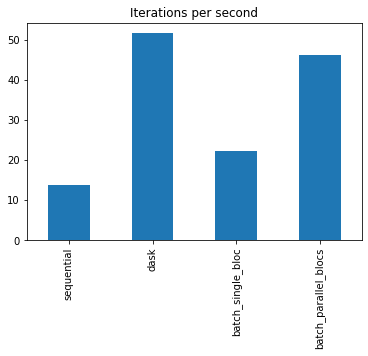

In [67]:
# pd.DataFrame(
pd.Series(iter_per_sec_stats).plot.bar(title='Iterations per second')

## Comparing options

In [68]:
if addresses.shape[0] > 500:
    addresses = addresses.sample(500)

In [ ]:
# Single call
results = {}
it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    results[(mode,  check_label, struct_label, extra_hn)] =  addresses.fillna("").apply(call_ws, 
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode,axis=1)

    it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(it_per_seconds))
print("Iterations per seconds (single calls):")
it_per_seconds = pd.DataFrame(it_per_seconds)
it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860


coordinates check unstruct extrahn
No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984


coordinates check unstruct noextrahn
No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804
5,coordinates,nocheck,struct,noextrahn,22.313689


coordinates nocheck unstruct extrahn
No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804
5,coordinates,nocheck,struct,noextrahn,22.313689
6,coordinates,nocheck,unstruct,extrahn,16.862198


coordinates nocheck unstruct noextrahn
No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804
5,coordinates,nocheck,struct,noextrahn,22.313689
6,coordinates,nocheck,unstruct,extrahn,16.862198
7,coordinates,nocheck,unstruct,noextrahn,17.814299


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804
5,coordinates,nocheck,struct,noextrahn,22.313689
6,coordinates,nocheck,unstruct,extrahn,16.862198
7,coordinates,nocheck,unstruct,noextrahn,17.814299
8,short,check,struct,extrahn,4.977098


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,4.938182
1,coordinates,check,struct,noextrahn,5.117860
2,coordinates,check,unstruct,extrahn,4.691984
3,coordinates,check,unstruct,noextrahn,4.894042
4,coordinates,nocheck,struct,extrahn,20.577804
5,coordinates,nocheck,struct,noextrahn,22.313689
6,coordinates,nocheck,unstruct,extrahn,16.862198
7,coordinates,nocheck,unstruct,noextrahn,17.814299
8,short,check,struct,extrahn,4.977098
9,short,check,struct,noextrahn,5.124165


short check unstruct extrahn
No result!
{'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto', 'referenceKey': '784'}



In [ ]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second", ax=fl_ax[i])
plt.tight_layout()
#     plt.show()

In [ ]:
f, ax = plt.subplots(4,4, figsize=(12,8))
for i, fld1 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    for j, fld2 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):

        it_per_seconds.groupby([fld1, fld2]).it_per_sec.mean().unstack().plot.bar(ax=ax[i][j])

In [ ]:
# results

In [ ]:
# batch
batch_results = {}
batch_it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    batch_results[(mode,  check_label, struct_label, extra_hn)] =  call_ws_batch(addresses,
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode)[0]

    batch_it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(batch_it_per_seconds))
print("Iterations per seconds (batch calls):")
batch_it_per_seconds = pd.DataFrame(batch_it_per_seconds)
batch_it_per_seconds

In [ ]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(batch_it_per_seconds.drop("it_per_sec", axis=1).columns):
    batch_it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second (batch)", ax=fl_ax[i])
plt.tight_layout()

In [ ]:
print("Match rate (without nostreet)")
mr=[]
for k1 in ["struct", "unstruct"]:
    for k2 in ["check", "nocheck"]:
        keys = [k for k in  batch_results.keys() if k1 in k and k2 in k]
        mr.append({"struct": k1, "check": k2, "match_rate": min([batch_results[k][batch_results[k][("metadata", "method")]!="nostreet" ].shape[0]/addresses.shape[0] for k in keys])})

mr = pd.DataFrame(mr).set_index(["struct","check" ]).unstack()

mr.plot.bar() 
mr